In [1]:
import cv2 as cv
import glob
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def calibrate_camera(images_folder):
    images_names = glob.glob(images_folder)
    print(images_names)
    images = []
    for imname in images_names:
        im = cv.imread(imname, 1)
        images.append(im)

    #criteria used by checkerboard pattern detector.
    #Change this if the code can't find the checkerboard
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
    rows = 6 #number of checkerboard rows.
    columns = 8 #number of checkerboard columns.
    world_scaling = 90.7 #mm #change this to the real world square size. Or not.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp
 
    #frame dimensions. Frames should be the same size.
    width = images[0].shape[1]
    height = images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints = [] # 2d points in image plane.
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
 
 
    for frame in images:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # plt.imshow(gray, cmap='gray')
        # plt.show()
 
        #find the checkerboard
        ret, corners = cv.findChessboardCorners(gray, (rows, columns), None)
        print(ret)
 
        if ret == True:
 
            #Convolution size used to improve corner detection. Don't make this too large.
            conv_size = (11, 11)
 
            #opencv can attempt to improve the checkerboard coordinates
            corners = cv.cornerSubPix(gray, corners, conv_size, (-1, -1), criteria)
            cv.drawChessboardCorners(frame, (rows,columns), corners, ret)
            plt.imshow(frame, cmap='gray')
            plt.show()
 
            objpoints.append(objp)
            imgpoints.append(corners)
 
 
 
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, (width, height), None, None)
    print('rmse:', ret)
    print('camera matrix:\n', mtx)
    print('distortion coeffs:', dist)
    print('Rs:\n', rvecs)
    print('Ts:\n', tvecs)
 
    return mtx, dist

In [22]:
def stereo_calibrate(mtx1, dist1, mtx2, dist2, frames_folder1, frames_folder2):
    #read the synched frames
    images_names1 = glob.glob(frames_folder1)
    images_names2 = glob.glob(frames_folder2)
    c1_images_names = sorted(images_names1)
    c2_images_names = sorted(images_names1)

    print(c1_images_names)
    print(c2_images_names)
    c1_images = []
    c2_images = []
    for im1, im2 in zip(c1_images_names, c2_images_names):
        _im = cv.imread(im1, 1)
        c1_images.append(_im)
 
        _im = cv.imread(im2, 1)
        c2_images.append(_im)

 
    #change this if stereo calibration not good.
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
 
    rows = 6 #number of checkerboard rows.
    columns = 9 #number of checkerboard columns.
    world_scaling = 90.7 #change this to the real world square size. Or not.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp
 
    #frame dimensions. Frames should be the same size.
    width = c1_images[0].shape[1]
    height = c1_images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
 
    for frame1, frame2 in zip(c1_images, c2_images):

        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
        c_ret1, corners1 = cv.findChessboardCorners(gray1, (6, 9), None)
        print(c_ret1)
        c_ret2, corners2 = cv.findChessboardCorners(gray2, (6, 9), None)
        print(c_ret2)
        
        if c_ret1 == True and c_ret2 == True:
            corners1 = cv.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
            corners2 = cv.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)
 
            cv.drawChessboardCorners(frame1, (6,9), corners1, c_ret1)
            plt.imshow(frame1, cmap='gray')
            plt.show()
 
            cv.drawChessboardCorners(frame2, (6,9), corners2, c_ret2)
            
 
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)
 
    stereocalibration_flags = cv.CALIB_FIX_INTRINSIC
    ret, CM1, dist1, CM2, dist2, R, T, E, F = cv.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,
                                                                 mtx2, dist2, (width, height), criteria = criteria, flags = stereocalibration_flags)
 
    print(ret)
    return R, T

['cam1\\0.jpeg', 'cam1\\1.jpeg', 'cam1\\10.jpeg', 'cam1\\11.jpeg', 'cam1\\2.jpeg', 'cam1\\3.jpeg', 'cam1\\4.jpeg', 'cam1\\5.jpeg', 'cam1\\6.jpeg', 'cam1\\7.jpeg', 'cam1\\8.jpeg', 'cam1\\9.jpeg']
True


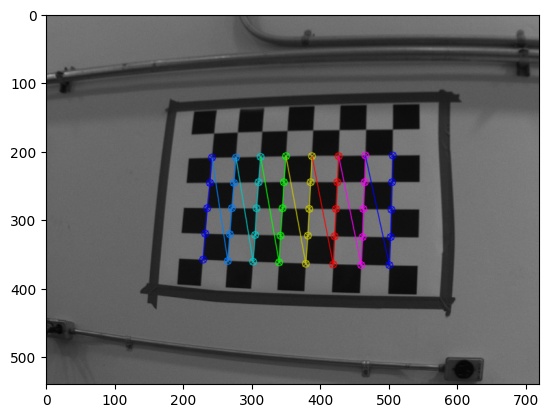

True


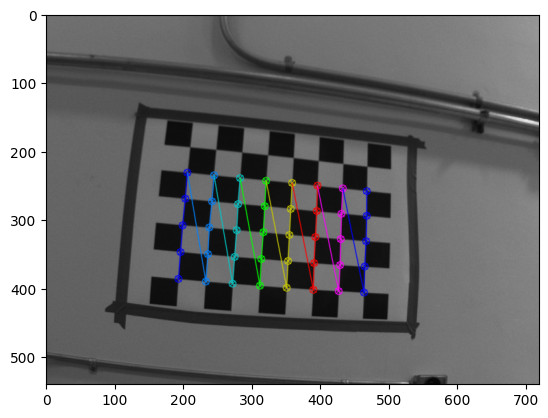

True


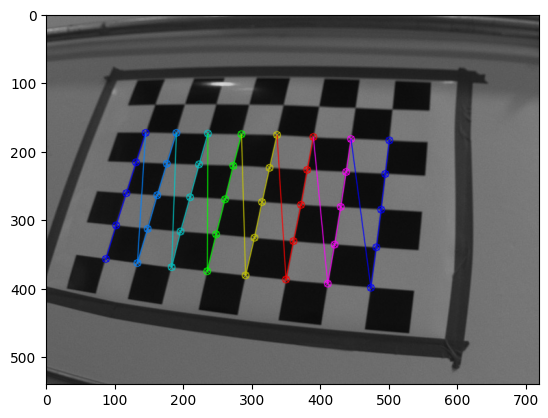

True


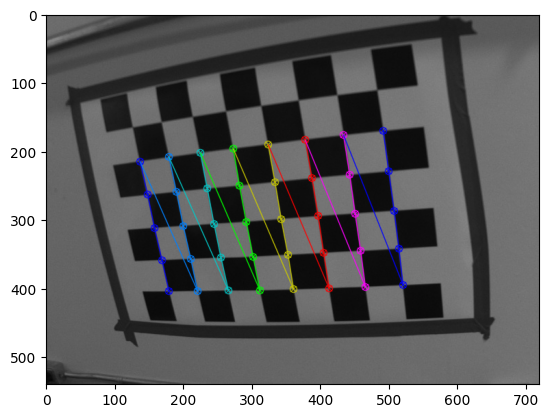

True


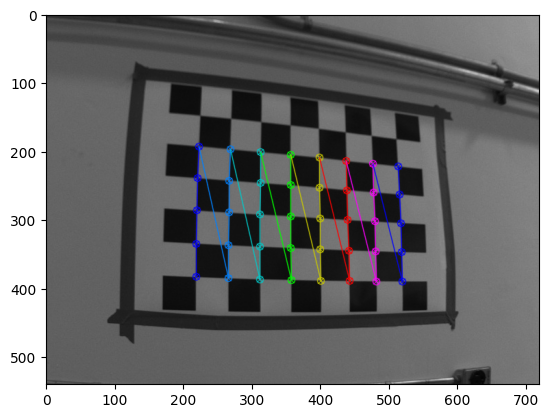

True


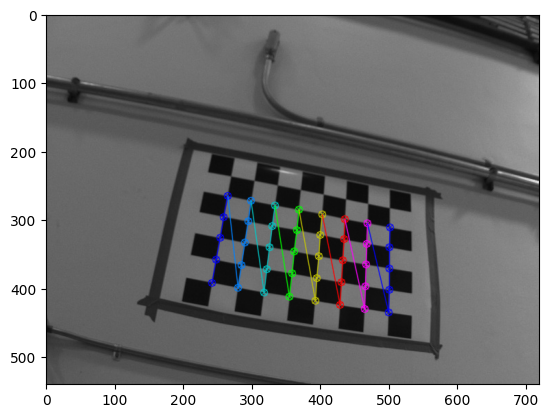

True


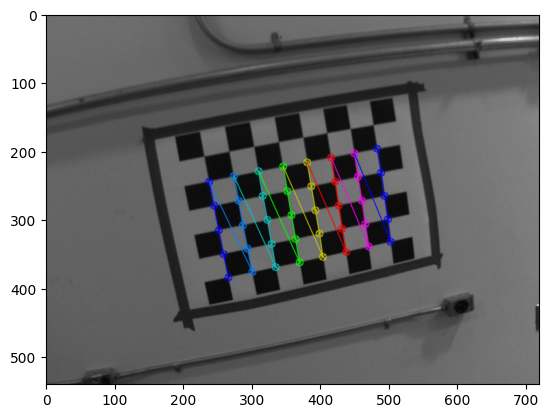

True


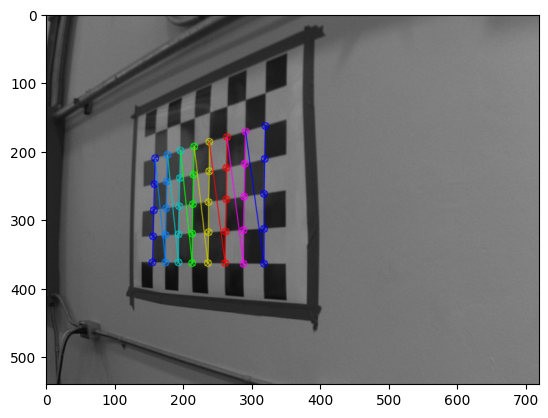

True


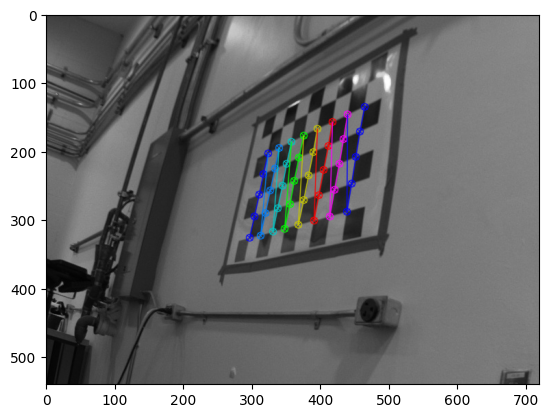

True


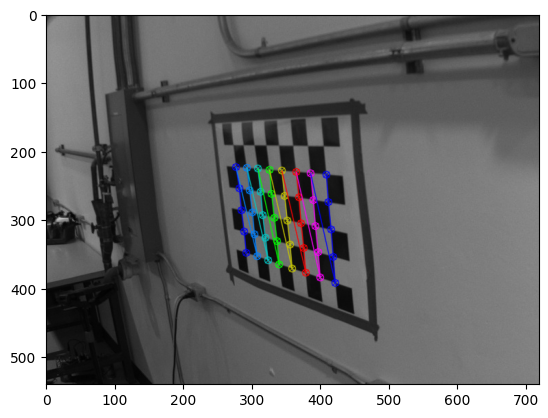

True


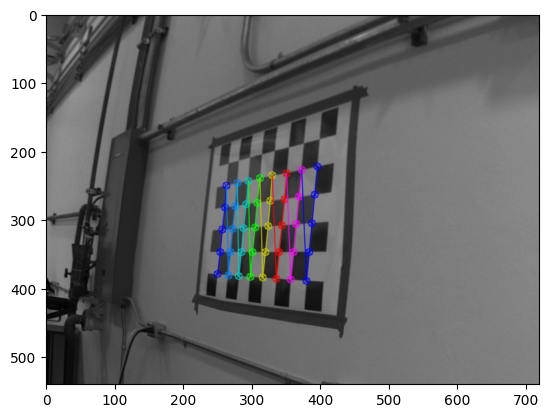

True


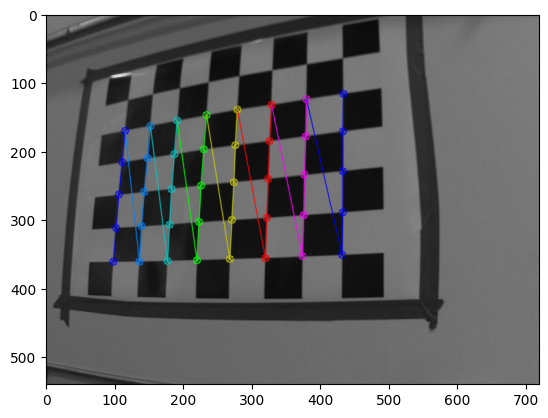

rmse: 0.31315306570464096
camera matrix:
 [[887.98312388   0.         360.15570667]
 [  0.         886.70327924 290.5869745 ]
 [  0.           0.           1.        ]]
distortion coeffs: [[-3.76881100e-01 -1.57471323e+00 -3.19989070e-03  3.96477184e-04
   1.31238064e+01]]
Rs:
 (array([[-0.35816949],
       [ 0.04571684],
       [-1.52007502]]), array([[-0.01114483],
       [-0.31611588],
       [-1.48701672]]), array([[-0.53747971],
       [-0.16710672],
       [-1.40663069]]), array([[-0.06178968],
       [ 0.4933923 ],
       [-1.66333948]]), array([[ 0.13796634],
       [-0.43018939],
       [-1.52008941]]), array([[-0.30731122],
       [-0.57096886],
       [-1.37361475]]), array([[ 0.28329722],
       [ 0.01219203],
       [-1.74818218]]), array([[-0.74657522],
       [ 0.61998741],
       [-1.49338135]]), array([[-1.08843229],
       [ 0.51022758],
       [-1.38001748]]), array([[-0.62135632],
       [ 0.95885656],
       [-1.41210868]]), array([[-0.90016332],
       [ 0.6486809

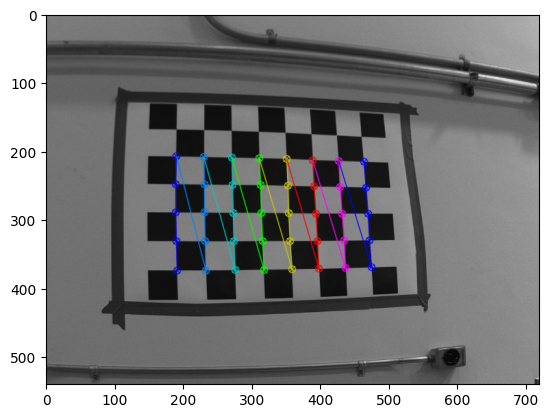

True


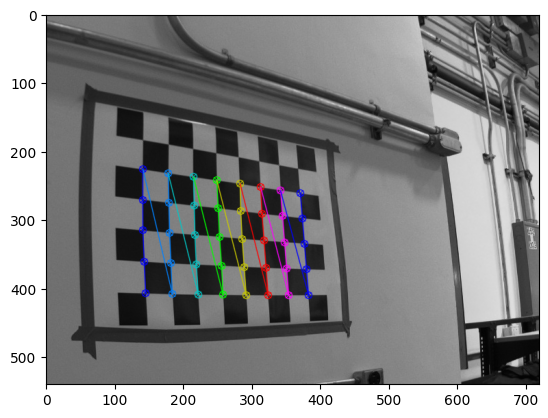

True


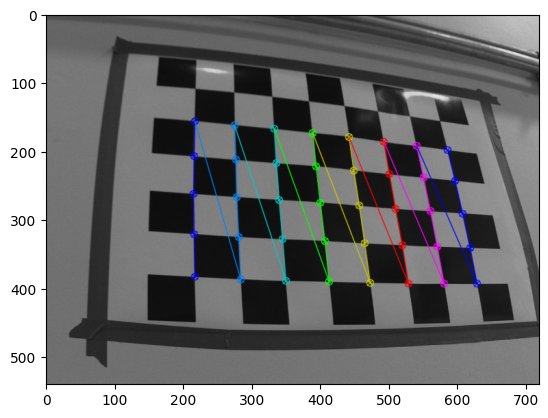

False
True


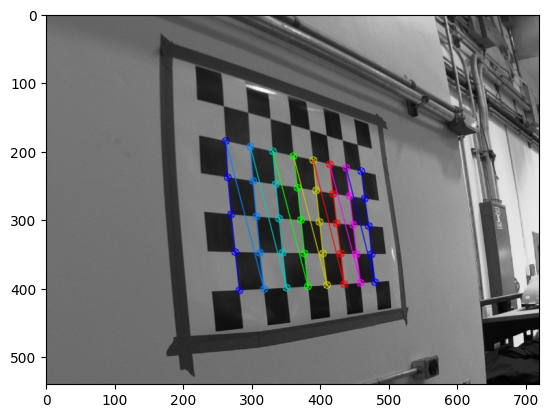

True


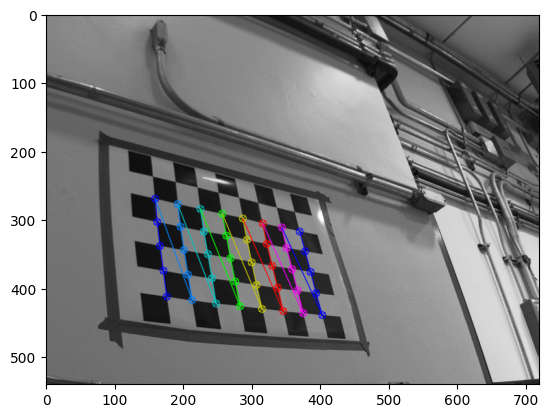

True


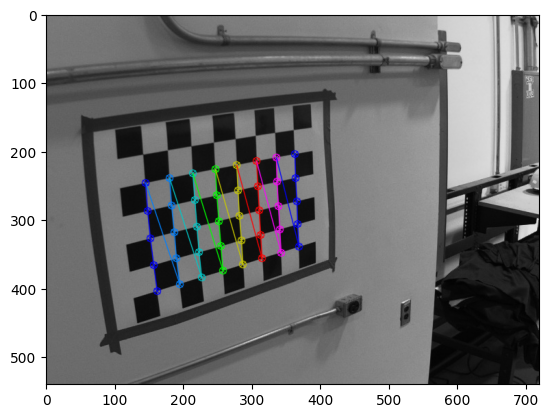

True


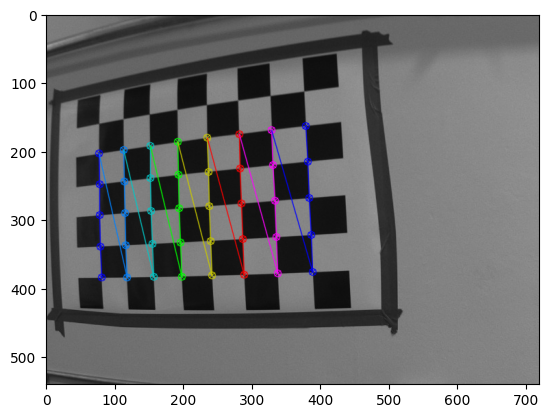

True


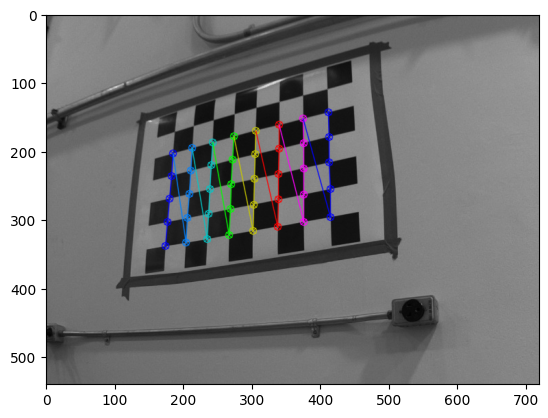

True


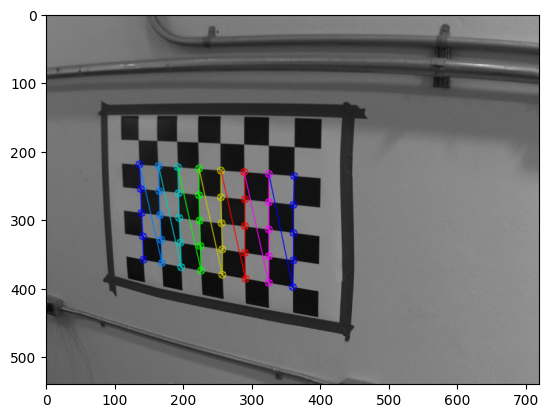

True


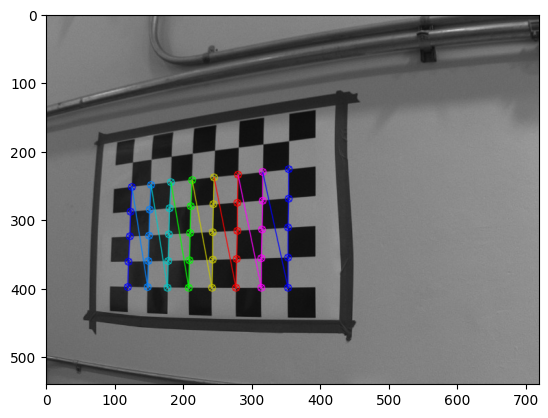

True


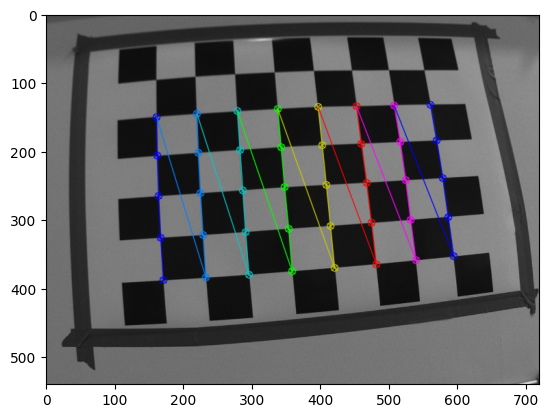

rmse: 0.30198196808111205
camera matrix:
 [[883.05746357   0.         385.02714461]
 [  0.         881.48643148 290.74915478]
 [  0.           0.           1.        ]]
distortion coeffs: [[-3.96785766e-01 -4.06941801e-01 -3.91684522e-04 -4.44033527e-04
   3.06178749e+00]]
Rs:
 (array([[ 0.06435878],
       [-0.39229944],
       [-1.57657124]]), array([[ 0.42531321],
       [-0.78392842],
       [-1.47129828]]), array([[-0.11418759],
       [-0.63780665],
       [-1.53669821]]), array([[ 0.58475943],
       [-0.89092845],
       [-1.46486225]]), array([[ 0.09876175],
       [-1.0524459 ],
       [-1.46501061]]), array([[ 0.78365375],
       [-0.41645187],
       [-1.60895848]]), array([[-0.28098754],
       [ 0.17355642],
       [-1.61672682]]), array([[-0.63850685],
       [ 0.07874408],
       [-1.61531899]]), array([[-0.18093102],
       [ 0.49182546],
       [-1.47931303]]), array([[-0.4514428 ],
       [ 0.20304758],
       [-1.57298675]]), array([[-0.04287285],
       [-0.2700782

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\calibration.cpp:3990: error: (-215:Assertion failed) nimages > 0 in function 'cv::stereoCalibrate'


In [23]:
mtx1, dist1 = calibrate_camera(images_folder = 'cam1/*')
mtx2, dist2 = calibrate_camera(images_folder = 'cam2/*')
 
R, T = stereo_calibrate(mtx1, dist1, mtx2, dist2, 'cam1/*', 'cam2/*')